In [1]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import pickle
import time
import uuid
import scipy as scp
import scipy.stats as scps
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load my own functions
import dnnregressor_train_eval_keras as dnnk
import make_data_wfpt as mdw
from kde_training_utilities import kde_load_data
import ddm_data_simulation as ddm_sim
import boundary_functions as bf

In [2]:
# Handle some cuda business

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16713969157984113450
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 622275412312356110
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12048649421
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 12488163351450518972
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13334411867122368333
physical_device_desc: "device: XLA_GPU device"
]


In [28]:
# Load Model
model_path = '/media/data_cifs/afengler/data/kde/ornstein_uhlenbeck/keras_models/dnnregressor_ornstein_uhlenbeck_06_28_19_00_43_25/model_0' 
ckpt_path = '/media/data_cifs/afengler/data/kde/ornstein_uhlenbeck/keras_models/dnnregressor_ornstein_uhlenbeck_06_28_19_00_43_25/ckpt_0_60'

model = keras.models.load_model(model_path)
model.load_weights(ckpt_path)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4880      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               8100      
_________________________________________________________________
dense_5 (Dense)              (None, 120)               12120     
__________

In [30]:
# Initializations -----
n_runs = 100
n_samples = 2500
feature_file_path = '/media/data_cifs/afengler/data/kde/ornstein_uhlenbeck/train_test_data/test_features.pickle'
mle_out_path = '/media/data_cifs/afengler/data/kde/ornstein_uhlenbeck/mle_runs'

# NOTE PARAMETERS: WEIBULL: [v, a, w, node, shape, scale]
param_bounds = [(-2, 2), (0.5, 2), (0.3, 0.7), (-1 , 1)]


# my_optim_columns = ['v_sim', 'a_sim', 'w_sim', 'node_sim', 'theta_sim',
#                     'v_mle', 'a_mle', 'w_mle', 'node_mle', 'theta_mle', 'n_samples']

# Get parameter names in correct ordering:
dat = pickle.load(open(feature_file_path, 
                       'rb'))

parameter_names = list(dat.keys())[:-2] # :-1 to get rid of 'rt' and 'choice' here

# Make columns for optimizer result table
p_sim = []
p_mle = []

for parameter_name in parameter_names:
    p_sim.append(parameter_name + '_sim')
    p_mle.append(parameter_name + '_mle')
    
my_optim_columns = p_sim + p_mle + ['n_samples']

# Initialize the data frame in which to store optimizer results
optim_results = pd.DataFrame(np.zeros((n_runs, len(my_optim_columns))), columns = my_optim_columns)
optim_results.iloc[:, 2 * len(parameter_names)] = n_samples

# define boundary
boundary = bf.constant
boundary_multiplicative = True

# Define the likelihood function
def log_p(params = [0, 1, 0.9], model = [], data = [], parameter_names = []):
    # Make feature array
    feature_array = np.zeros((data[0].shape[0], len(parameter_names) + 2))
    
    # Store parameters
    cnt = 0
    for i in range(0, len(parameter_names), 1):
        feature_array[:, i] = params[i]
        cnt += 1
    
    # Store rts and choices
    feature_array[:, cnt] = data[0].ravel() # rts
    feature_array[:, cnt + 1] = data[1].ravel() # choices
    
    # Get model predictions
    prediction = model.predict(feature_array)
    
    # Some post-processing of predictions
    prediction[prediction < 1e-29] = 1e-29
    
    return(- np.sum(np.log(prediction)))  

def make_params(param_bounds = []):
    params = np.zeros(len(param_bounds))
    
    for i in range(len(params)):
        params[i] = np.random.uniform(low = param_bounds[i][0], high = param_bounds[i][1])
        
    return params
# ---------------------

In [31]:
my_optim_columns

['v_sim',
 'a_sim',
 'w_sim',
 'g_sim',
 'v_mle',
 'a_mle',
 'w_mle',
 'g_mle',
 'n_samples']

In [ ]:
# Main loop ----------- TD: Parallelize
for i in range(0, n_runs, 1): 
    
    # Get start time
    start_time = time.time()
    
    tmp_params = make_params(param_bounds = param_bounds)
    
    # Store in output file
    optim_results.iloc[i, :len(parameter_names)] = tmp_params
    
    # Print some info on run
    print('Parameters for run ' + str(i) + ': ')
    print(tmp_params)
    
    # Define boundary params
    # Linear Collapse
#     boundary_params = {'node': tmp_params[3],
#                        'theta': tmp_params[4]}
    
    # Constant
    boundary_params = {}
    
    # Run model simulations
    ddm_dat_tmp = ddm_sim.ddm_flexbound_simulate(v = tmp_params[0],
                                                 a = tmp_params[1],
                                                 w = tmp_params[2],
                                                 s = 1,
                                                 delta_t = 0.001,
                                                 max_t = 20,
                                                 n_samples = n_samples,
                                                 boundary_fun = boundary, # function of t (and potentially other parameters) that takes in (t, *args)
                                                 boundary_multiplicative = boundary_multiplicative, # CAREFUL: CHECK IF BOUND
                                                 boundary_params = boundary_params)
        
    # Print some info on run
    print('Mean rt for current run: ')
    print(np.mean(ddm_dat_tmp[0]))
    
    # Run optimizer
    out = differential_evolution(log_p, 
                                 bounds = param_bounds, 
                                 args = (model, ddm_dat_tmp, parameter_names), 
                                 popsize = 30,
                                 disp = True)
    
    # Print some info
    print('Solution vector of current run: ')
    print(out.x)
    
    print('The run took: ')
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    # Store result in output file
    optim_results.iloc[i, len(parameter_names):(2*len(parameter_names))] = out.x
# -----------------------

# Save optimization results to file
optim_results.to_csv(mle_out_path + '/mle_results_' + uuid.uuid1().hex + '.csv')

Parameters for run 0: 
[0.39100681 1.48589743 0.41143248 0.85180774]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
2.067422799999939
differential_evolution step 1: f(x)= 5444.75
differential_evolution step 2: f(x)= 5444.75
differential_evolution step 3: f(x)= 5413.35
differential_evolution step 4: f(x)= 5379.64
differential_evolution step 5: f(x)= 5357.43
differential_evolution step 6: f(x)= 5357.43
differential_evolution step 7: f(x)= 5357.43
differential_evolution step 8: f(x)= 5357.43
differential_evolution step 9: f(x)= 5350.61
differential_evolution step 10: f(x)= 5345.79
differential_evolution step 11: f(x)= 5331.23
Solution vector of current run: 
[ 0.54005834  1.28886055  0.34641769 -0.02734877]
The run took: 
00:04:02
Parameters for run 1: 
[-0.78809162  1.67188632  0.44869875  0.55899007]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
1.6983283999999415
differential_evolutio

differential_evolution step 22: f(x)= 2505.12
differential_evolution step 23: f(x)= 2504.63
differential_evolution step 24: f(x)= 2504.63
differential_evolution step 25: f(x)= 2497.88
differential_evolution step 26: f(x)= 2495.11
differential_evolution step 27: f(x)= 2493.5
differential_evolution step 28: f(x)= 2491.81
differential_evolution step 29: f(x)= 2491.81
differential_evolution step 30: f(x)= 2491.81
differential_evolution step 31: f(x)= 2491.81
differential_evolution step 32: f(x)= 2491.81
differential_evolution step 33: f(x)= 2491.78
differential_evolution step 34: f(x)= 2491.6
differential_evolution step 35: f(x)= 2491.6
Solution vector of current run: 
[-0.7019916   1.99867101  0.38106882 -0.75855228]
The run took: 
00:06:19
Parameters for run 5: 
[-0.42520084  0.86651451  0.3389716  -0.78498488]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.611763999999988
differential_evolution step 1: f(x)= 2328.65
differential_evolu

differential_evolution step 15: f(x)= 2235.31
differential_evolution step 16: f(x)= 2235.31
differential_evolution step 17: f(x)= 2232.32
differential_evolution step 18: f(x)= 2230.14
differential_evolution step 19: f(x)= 2226.12
differential_evolution step 20: f(x)= 2226.12
differential_evolution step 21: f(x)= 2226.12
differential_evolution step 22: f(x)= 2226.12
differential_evolution step 23: f(x)= 2226.12
Solution vector of current run: 
[-1.99713693  1.17218575  0.68454519  0.98523841]
The run took: 
00:04:31
Parameters for run 11: 
[-1.21385427  0.68775557  0.33400973 -0.0872726 ]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.3157427999999989
differential_evolution step 1: f(x)= 533.508
differential_evolution step 2: f(x)= 243.544
differential_evolution step 3: f(x)= 243.544
differential_evolution step 4: f(x)= 243.544
differential_evolution step 5: f(x)= 223.341
differential_evolution step 6: f(x)= 159.061
differential_evolu

differential_evolution step 5: f(x)= 3528.24
differential_evolution step 6: f(x)= 3528.24
differential_evolution step 7: f(x)= 3528.24
differential_evolution step 8: f(x)= 3514.34
differential_evolution step 9: f(x)= 3514.34
differential_evolution step 10: f(x)= 3514.34
differential_evolution step 11: f(x)= 3501.98
differential_evolution step 12: f(x)= 3501.98
differential_evolution step 13: f(x)= 3501.98
differential_evolution step 14: f(x)= 3501.98
differential_evolution step 15: f(x)= 3501.98
differential_evolution step 16: f(x)= 3497.05
differential_evolution step 17: f(x)= 3497.05
differential_evolution step 18: f(x)= 3496.11
Solution vector of current run: 
[1.06658071 1.03205201 0.30588334 0.24846848]
The run took: 
00:03:48
Parameters for run 16: 
[-1.88316695  0.88514529  0.46218817  0.18643386]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.43196119999999827
differential_evolution step 1: f(x)= 394.119
differential_evolutio

differential_evolution step 34: f(x)= 526.281
differential_evolution step 35: f(x)= 526.281
differential_evolution step 36: f(x)= 526.194
differential_evolution step 37: f(x)= 526.194
differential_evolution step 38: f(x)= 526.194
differential_evolution step 39: f(x)= 526.194
differential_evolution step 40: f(x)= 525.83
differential_evolution step 41: f(x)= 525.83
differential_evolution step 42: f(x)= 525.83
differential_evolution step 43: f(x)= 525.152
differential_evolution step 44: f(x)= 524.908
differential_evolution step 45: f(x)= 524.908
differential_evolution step 46: f(x)= 524.908
differential_evolution step 47: f(x)= 524.908
differential_evolution step 48: f(x)= 524.827
differential_evolution step 49: f(x)= 524.827
Solution vector of current run: 
[ 1.99817791  1.50966886  0.6385679  -0.96835824]
The run took: 
00:08:03
Parameters for run 21: 
[ 0.90321301  0.52422933  0.37486648 -0.88906424]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for cu

differential_evolution step 24: f(x)= 1586.09
differential_evolution step 25: f(x)= 1586.09
differential_evolution step 26: f(x)= 1586.09
differential_evolution step 27: f(x)= 1586.09
differential_evolution step 28: f(x)= 1586.09
differential_evolution step 29: f(x)= 1586.09
differential_evolution step 30: f(x)= 1586.09
Solution vector of current run: 
[-1.20490632  1.04033156  0.43773364  0.49906285]
The run took: 
00:05:14
Parameters for run 25: 
[-1.83337544  1.32610585  0.65716771  0.7845787 ]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.9151643999999833
differential_evolution step 1: f(x)= 1695.46
differential_evolution step 2: f(x)= 1695.46
differential_evolution step 3: f(x)= 1666.64
differential_evolution step 4: f(x)= 1614.97
differential_evolution step 5: f(x)= 1591.35
differential_evolution step 6: f(x)= 1591.35
differential_evolution step 7: f(x)= 1591.35
differential_evolution step 8: f(x)= 1578.81
differential_evoluti

In [23]:
os.listdir(mle_out_path)

['mle_results_3.csv', 'mle_results_1.csv']

In [11]:
# Read in results
optim_results = pd.read_csv(mle_out_path + '/' + mle_out_files[0])

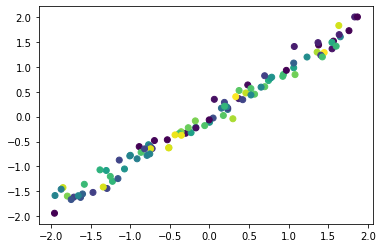

In [12]:
plt.scatter(optim_results['v_sim'], optim_results['v_mle'], c = optim_results['w_mle'])

In [13]:
# Regression for v
reg = LinearRegression().fit(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))
reg.score(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))

0.983481502870897

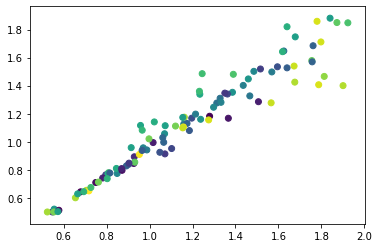

In [21]:
plt.scatter(optim_results['a_sim'], optim_results['a_mle'], c = optim_results['v_sim'])

In [16]:
# Regression for a
reg = LinearRegression().fit(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))
reg.score(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))

0.9234082884219005

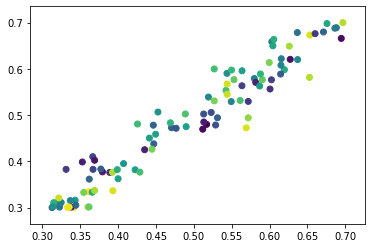

In [22]:
plt.scatter(optim_results['w_sim'], optim_results['w_mle'], c = optim_results['v_sim'])

In [18]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))
reg.score(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))

0.9336386839870727

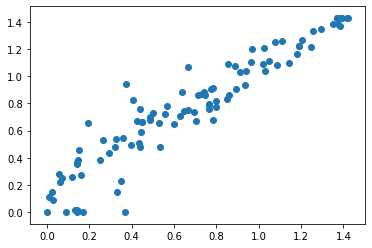

In [15]:
plt.scatter(optim_results['theta_sim'], optim_results['theta_mle'])

In [17]:
# Regression for c1
reg = LinearRegression().fit(np.expand_dims(optim_results['theta_mle'], 1), np.expand_dims(optim_results['theta_sim'], 1))
reg.score(np.expand_dims(optim_results['theta_mle'], 1), np.expand_dims(optim_results['theta_sim'], 1))

0.8890366364460973

In [ ]:
plt.scatter(optim_results['c2_sim'], optim_results['c2_mle'], c = optim_results['a_mle'])

In [ ]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))
reg.score(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))